In [1]:
# Install necessary libraries
! pip install --quiet \
  sentence_transformers==1.0.4 \

# Setup connection with your own google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Clone branch from github
!rm -rf policy-data-analyzer/
! branch_name='master' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 5586 (delta 179), reused 191 (delta 83), pack-reused 5263
Receiving objects: 100% (5586/5586), 204.12 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (2944/2944), done.
Checking out files: 100% (1165/1165), done.


In [3]:
#If you run this cell more than once, comment out this line because you are already in this folder and you will get an error
import os
os.chdir("policy-data-analyzer") 

from tasks.data_loading.src.utils import *
from sklearn.model_selection import train_test_split

In [4]:
"""
MAKE SURE THAT THIS IS ALWAYS YOUR INDIVIDUAL NUMBER (FOR REASONS TO NOT OVERWRITE DATA)
"""

GLOBAL_EXPERIMENT_NUMBER = 8

Please do not overwrite existing models and their results from previous experiments
You are writing to Experiment # 8


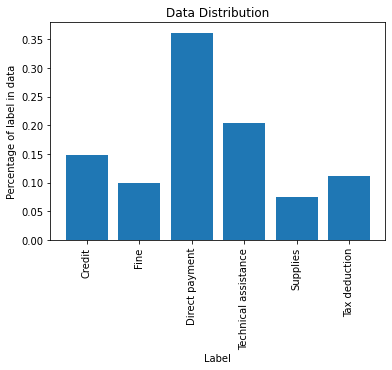

Label counts:
{'Credit': 0.14759036144578314, 'Fine': 0.09939759036144578, 'Direct payment': 0.3614457831325301, 'Technical assistance': 0.20481927710843373, 'Supplies': 0.07530120481927711, 'Tax deduction': 0.11144578313253012}


In [5]:
experiment = "EXP18"
classifier = "Multiclass"

base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/Spanish/datasets/{classifier}"

results_save_path = f"{base_path}/Modeling/Model_reproducibility/Model_results/\
                                {classifier}ClassificationExperiments/{GLOBAL_EXPERIMENT_NUMBER}/"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
    print(f"Making new experiment folder for experiment # {GLOBAL_EXPERIMENT_NUMBER}")
else:
    print("Please do not overwrite existing models and their results from previous experiments")
    print(f"You are writing to Experiment # {GLOBAL_EXPERIMENT_NUMBER}")

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
numeric_train_labels = labels2numeric(train_labels, label_names)
label2int = dict(zip(label_names, range(len(label_names))))
X_train, X_dev, y_train, y_dev = train_test_split(train_sents, train_labels, test_size=0.2,
                                                            stratify=train_labels, random_state=100)

plot_data_distribution(numeric_train_labels, label_names)

In [6]:
"""
This examples trains a CrossEncoder for the NLI task. A CrossEncoder takes a sentence pair
as input and outputs a label. Here, it learns to predict the labels: "contradiction": 0, "entailment": 1, "neutral": 2.
It does NOT produce a sentence embedding and does NOT work for individual sentences.
Usage:
python training_nli.py
"""

from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryAccuracyEvaluator, CESoftmaxAccuracyEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import os
import gzip
import csv

In [9]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout

train_samples = []
for sent, label in zip(X_train, y_train):
    label_id = label2int[label]
    train_samples.append(InputExample(texts=[sent, sent], label=label_id))

dev_samples = []
for sent, label in zip(X_dev, y_dev):
    label_id = label2int[label]
    dev_samples.append(InputExample(texts=[sent, sent], label=label_id))

train_batch_size = 16
num_epochs = 20
# model_save_path = 'output/training_allnli-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#Define our CrossEncoder model. We use distilroberta-base as basis and setup it up to predict 3 labels
model = CrossEncoder('bert-base-multilingual-uncased', num_labels=len(label2int))

#We wrap train_samples, which is a list ot InputExample, in a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

#During training, we use CESoftmaxAccuracyEvaluator to measure the accuracy on the dev set.
evaluator = CESoftmaxAccuracyEvaluator.from_input_examples(dev_samples, name='EXP18')

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=10000,
          warmup_steps=warmup_steps)
          # output_path=model_save_path)


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

2021-04-13 15:56:00 - Use pytorch device: cuda
2021-04-13 15:56:01 - Warmup-steps: 34



2021-04-13 15:56:11 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 0:
2021-04-13 15:56:11 - Accuracy: 23.88



2021-04-13 15:56:20 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 1:
2021-04-13 15:56:21 - Accuracy: 35.82



2021-04-13 15:56:30 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 2:
2021-04-13 15:56:30 - Accuracy: 43.28



2021-04-13 15:56:39 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 3:
2021-04-13 15:56:39 - Accuracy: 56.72



2021-04-13 15:56:48 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 4:
2021-04-13 15:56:49 - Accuracy: 65.67



2021-04-13 15:56:58 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 5:
2021-04-13 15:56:58 - Accuracy: 67.16



2021-04-13 15:57:07 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 6:
2021-04-13 15:57:07 - Accuracy: 73.13



2021-04-13 15:57:15 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 7:
2021-04-13 15:57:16 - Accuracy: 76.12



2021-04-13 15:57:24 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 8:
2021-04-13 15:57:25 - Accuracy: 82.09



2021-04-13 15:57:34 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 9:
2021-04-13 15:57:35 - Accuracy: 80.60



2021-04-13 15:57:43 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 10:
2021-04-13 15:57:43 - Accuracy: 82.09



2021-04-13 15:57:52 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 11:
2021-04-13 15:57:53 - Accuracy: 80.60



2021-04-13 15:58:01 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 12:
2021-04-13 15:58:02 - Accuracy: 80.60



2021-04-13 15:58:10 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 13:
2021-04-13 15:58:11 - Accuracy: 83.58



2021-04-13 15:58:20 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 14:
2021-04-13 15:58:20 - Accuracy: 80.60



2021-04-13 15:58:29 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 15:
2021-04-13 15:58:30 - Accuracy: 82.09



2021-04-13 15:58:38 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 16:
2021-04-13 15:58:39 - Accuracy: 83.58



2021-04-13 15:58:47 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 17:
2021-04-13 15:58:48 - Accuracy: 80.60



2021-04-13 15:58:57 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 18:
2021-04-13 15:58:57 - Accuracy: 83.58



2021-04-13 15:59:06 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP18 dataset after epoch 19:
2021-04-13 15:59:06 - Accuracy: 83.58

